# 3D Magnetic Inversion of Raglan Data with Lp-norm

In this notebook, we inverted the magnetic data acquired at [Raglan deposit](https://en.wikipedia.org/wiki/Raglan_Mine) located in Northern Quebec, Canada to obtain a three-dimensional susceptibility model of the subsurface. Magnetic module of an open-source geophysics software, [SimPEG ](https://www.simpeg.xyz) was used for this inversion. 

About 20 years ago, this data was inverted using the [MAG3D code](https://mag3d.readthedocs.io/en/latest/content/overview.html) developed by [UBC-GIF](https://gif.eos.ubc.ca/about) group, and a 3D susceptibility model was obtained. This was sort of the first time that field magnetic data was inverted in 3D, and made a significant impact on locating drilling location for a mineral exploration. 

In the [previous notebook](./1-magnetic-inversion-raglan-reproduce), we inverted these magnetic data using an L2-norm inversion. To promote the compactness of the target body, we used the Lp-norm inversion approach (Founier and Oldenburg, 2019). 

<center>
<img src="./figures/mag3disco.gif", class="center"></img>
</center>

## Import modules




In [1]:
%matplotlib inline
import matplotlib
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh
from discretize.utils import mesh_builder_xyz

from SimPEG.potential_fields import magnetics
from SimPEG import dask
from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import pandas as pd
from ipywidgets import widgets, interact

## Load Data and Plot

In [2]:
def read_ubc_magnetic_data(data_filename):
    with open(data_filename, 'r') as f:
        lines = f.readlines()
    tmp = np.array(lines[0].split()[:3]).astype(float)
    n_data = int(float(lines[2].split()[0]))
    meta_data = {}
    meta_data['inclination'] = float(tmp[0])
    meta_data['declination'] = float(tmp[1])
    meta_data['b0'] = float(tmp[2])
    meta_data['n_data'] = n_data
    data = np.zeros((n_data, 5), order='F')
    for i_data in range(n_data):
        data[i_data,:] = np.array(lines[3+i_data].split()).astype(float)
    df = pd.DataFrame(data=data, columns=['x', 'y', 'z', 'data', 'data_error'])
    return df, meta_data

In [3]:
data_filename = "./data/Raglan_1997/obs.mag"
df, meta_data = read_ubc_magnetic_data(data_filename)

In [4]:
meta_data

{'inclination': 83.0, 'declination': -32.0, 'b0': 60000.0, 'n_data': 1638}

In [5]:
df.head(3)

,x,y,z,data,data_error
0,509.0,42958.0,40.0,42.90,5.8580
1,504.0,42858.0,40.0,88.32,6.7664
2,499.3,42758.0,40.0,86.11,6.7222


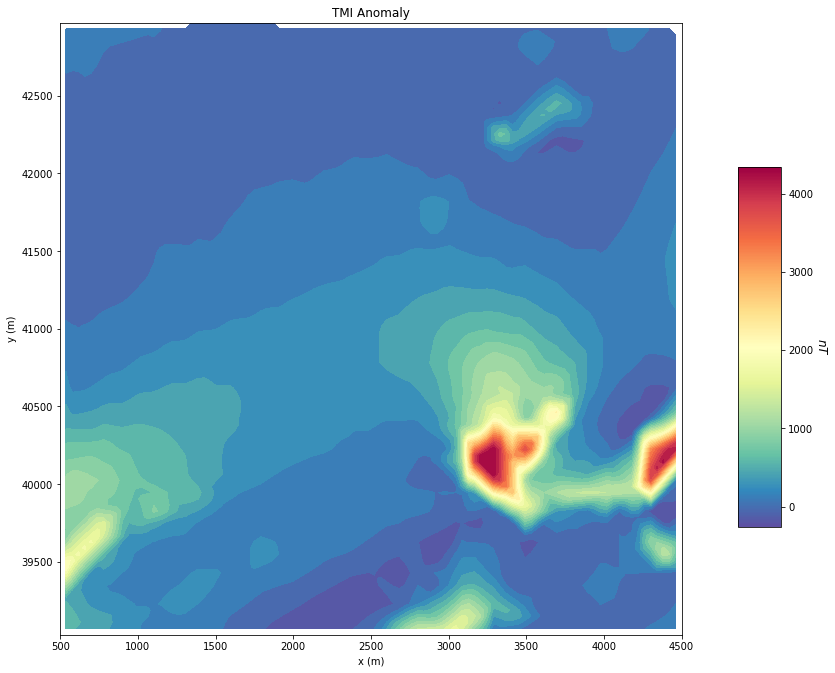

In [6]:
# Down sample the data
matplotlib.rcParams['font.size'] = 14
nskip = 2
receiver_locations = df[['x', 'y', 'z']].values[::nskip,:]
xyz_topo = np.c_[receiver_locations[:,:2], np.zeros(receiver_locations.shape[0])]
dobs = df['data'].values[::nskip]
# Plot
fig = plt.figure(figsize=(12, 10))
vmin, vmax = np.percentile(dobs, 0.5), np.percentile(dobs, 99.5)
tmp = np.clip(dobs, vmin, vmax)
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(
    receiver_locations,
    tmp,
    ax=ax1,
    ncontour=30,
    clim=(vmin-5, vmax+5),
    contourOpts={"cmap": "Spectral_r"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.25, 0.05, 0.5])

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.Spectral_r
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

## Assign Uncertainty

Inversion with SimPEG requires that we define data error i.e., standard deviation on the observed data.
This represents our estimate of the noise in our data. 
For this magnetic inversion, 2% relative error and a noise floor of 2 nT are assigned. 

In [7]:
standard_deviation = 0.02 * abs(dobs) + 2

## Defining the Survey

Here, we define a survey object that will be used for the simulation. 
The user needs an (N, 3) array to define
the xyz locations of the observation locations and the list of field components
which are to be modeled and the properties of the Earth's field.

In [8]:
# Define the component(s) of the field we are inverting as a list. Here we will
# Invert total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = meta_data['inclination']
declination = meta_data['declination']
strength = meta_data['b0']
inducing_field = (strength, inclination, declination)

source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

## Defining the Data

Here is where we define the data that is inverted. The data is defined by
the survey, the observation values and the standard deviations.




In [9]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used to invert TMI data.
If desired, we could define an OcTree mesh.

In [10]:
dx = 100 
dy = 100
dz = 100
depth_core = 1000
padding_distance_x_left = 1000
padding_distance_x_right = 1000
padding_distance_y_left = 1000
padding_distance_y_right= 1000
padding_distance_z_lower = 1000
padding_distance_z_upper = 0
mesh = mesh_builder_xyz(
    xyz=xyz_topo, 
    h=[dx, dy, dz], 
    depth_core=depth_core, 
    padding_distance=[
        [padding_distance_x_left, padding_distance_x_right], 
        [padding_distance_y_left, padding_distance_y_right], 
        [padding_distance_z_lower, padding_distance_z_upper]
    ]
)

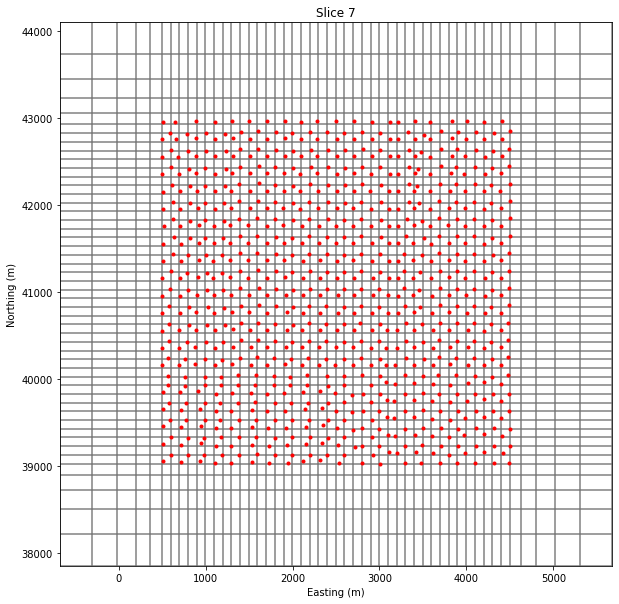

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mesh.plotSlice(np.ones(mesh.nC)*np.nan, ax=ax, grid=True)
ax.plot(receiver_locations[:,0], receiver_locations[:,1], 'r.')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect(1)

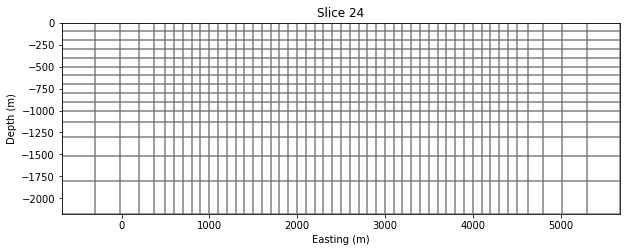

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mesh.plotSlice(np.ones(mesh.nC)*np.nan, ax=ax, grid=True, normal='Y')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Depth (m)")
ax.set_aspect(1)

## Starting/Reference Model and Mapping on Tensor Mesh

Here, we would create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the background is 1e-4 SI.




In [13]:
# Define background susceptibility model in SI. Don't make this 0!
# Otherwise the gradient for the 1st iteration is zero and the inversion will
# not converge.
background_susceptibility = 1e-4

# Find the indecies of the active cells in forward model (ones below surface)
ind_active = surface2ind_topo(mesh, np.c_[receiver_locations[:,:2], np.zeros(survey.nD)])

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each cell

# Define starting model
starting_model = background_susceptibility * np.ones(nC)
reference_model = np.zeros(nC) 

## Define the Physics

Here, we define the physics of the magnetics problem by using the simulation
class.




In [14]:
# Define the problem. Define the cells below topography and the mapping
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    modelType="susceptibility",
    chiMap=model_map,
    actInd=ind_active,
)

## Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem




In [15]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    indActive=ind_active,
    mapping=model_map,
    mref=reference_model,
    gradientType="total",
    alpha_s=1,
    alpha_x=1,
    alpha_y=1,
    alpha_z=1,
)

# Define sparse and blocky norms ps, px, py, pz
ps = 0
px = 2
py = 2
pz = 2
reg.norms = np.c_[ps, px, py, pz]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=0.0, upper=np.Inf, maxIterLS=20, maxIterCG=30, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [16]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Options for outputting recovered models and predicted data as a dictionary
save_dictionary = directives.SaveOutputDictEveryIteration()

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-3, max_irls_iterations=20, coolEpsFact=1.5, beta_tol=1e-2,
    chifact_target=1, chifact_start=1
)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)
opt.remember('xc')
# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save_dictionary,
    update_IRLS,
    update_jacobi,
]

## Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [17]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Print target misfit to compare with convergence
# print("Target misfit is " + str(target_misfit.target))

# Run the inversion
recovered_model = inv.run(starting_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
((819,), (18375, 18375))
Computing sensitivities to local ram
[########################################] | 100% Completed | 12.8s
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.22e+06  3.24e+05  4.09e-06  3.24e+05    7.59e+05      0              
   1  2.61e+06  9.13e+04  5.12e-03  1.05e+05    4.15e+05      0              
   2  1.30e+06  4.13e+04  1.23e-02  5.74e+04    1.37e+05      0   Skip BFGS  
   3  6.52e+05  2.85e+04  1.87e-02  4.08e+04    1.76e+05      0   Skip BFGS  
   4  3.26e+05  1.78e+04  2.85e-02  2.71e+04    1.25e+05      0   Skip BFGS  
   5  1.63e+05  1.49e+04  3.44e-02  2.05e+04    1.17e+05    

In [18]:
def plot_tikhonov_curve(iteration):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_dictionary.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_dictionary.outDict[kk]['phi_d'])
        phi_m.append(save_dictionary.outDict[kk]['phi_m'])
        beta.append(save_dictionary.outDict[kk]['beta'])
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(phi_m ,phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1] ,phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    axs[1].plot(iterations, phi_d, 'k.-')
    axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    ax_1 = axs[1].twinx()
    ax_1.plot(iterations, phi_m, 'r.-')
    ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    plt.tight_layout()    

In [19]:
interact(plot_tikhonov_curve, iteration=widgets.IntSlider(min=1, max=len(save_dictionary.outDict), step=1))

interactive(children=(IntSlider(value=1, description='iteration', max=32, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_tikhonov_curve(iteration)>

In [20]:
susceptibility_model = save_dictionary.outDict[31]['m']

In [21]:
def plot_model_histogram(iteration, yscale):
    out = plt.hist(save_dictionary.outDict[iteration]['m'], bins=np.linspace(0, 0.1))
    plt.xlabel('Susceptibility (SI)')
    plt.yscale(yscale)
    plt.ylabel('Counts')
#     plt.ylim(10, 1e5)


In [22]:
interact(
    plot_model_histogram, 
    iteration=widgets.IntSlider(min=1, max=len(save_dictionary.outDict), step=1),
    yscale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, description='iteration', max=32, min=1), RadioButtons(description='ys…

<function __main__.plot_model_histogram(iteration, yscale)>

In [23]:
def plot_dobs_vs_dpred(iteration):
    # Predicted data with final recovered model
    dpred = save_dictionary.outDict[iteration]['dpred']

    # Observed data | Predicted data | Normalized data misfit
    data_array = np.c_[dobs, dpred, (dobs - dpred) / standard_deviation]
    vmin, vmax = dobs.min(), dobs.max()
    fig = plt.figure(figsize=(17, 4))
    plot_title = ["Observed", "Predicted", "Normalized Misfit"]
    plot_units = ["nT", "nT", ""]

    ax1 = 3 * [None]
    ax2 = 3 * [None]
    norm = 3 * [None]
    cbar = 3 * [None]
    cplot = 3 * [None]
    v_lim = [(vmin, vmax), (vmin, vmax),(-3,3)]

    for ii in range(0, 3):

        ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.25, 0.84])
        cplot[ii] = plot2Ddata(
            receiver_list[0].locations,
            data_array[:, ii],
            ax=ax1[ii],
            ncontour=30,
            clim=v_lim[ii],
            contourOpts={"cmap": "Spectral_r"},
        )
        ax1[ii].set_title(plot_title[ii])
        ax1[ii].set_xlabel("x (m)")
        ax1[ii].set_ylabel("y (m)")

        ax2[ii] = fig.add_axes([0.33 * ii + 0.27, 0.11, 0.01, 0.84])
        norm[ii] = mpl.colors.Normalize(vmin=v_lim[ii][0], vmax=v_lim[ii][1])
        cbar[ii] = mpl.colorbar.ColorbarBase(
            ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.Spectral_r
        )
        cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)
    for ax in ax1[1:]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    plt.show()

In [24]:
interact(plot_dobs_vs_dpred, iteration=widgets.IntSlider(min=1, max=len(save_dictionary.outDict), step=1, value=1))

interactive(children=(IntSlider(value=1, description='iteration', max=32, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_dobs_vs_dpred(iteration)>

In [25]:
def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
    fig = plt.figure(figsize=(10, 10))
    mesh.plot_3d_slicer(
        save_dictionary.outDict[iteration]['m'], clim=(0, vmax),
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap':'Spectral_r'}
    )
interact(
    plot_recovered_model, 
    iteration=widgets.IntSlider(min=1, max=len(save_dictionary.outDict), value=0),
    xslice=widgets.FloatText(value=2000, step=100),
    yslice=widgets.FloatText(value=41000, step=100),
    zslice=widgets.FloatText(value=-800, step=100),
    vmax=widgets.FloatText(value=0.07),
)

interactive(children=(IntSlider(value=1, description='iteration', max=32, min=1), FloatText(value=2000.0, desc…

<function __main__.plot_recovered_model(iteration, xslice, yslice, zslice, vmax)>

## Comparing the historic model with the recovered model


In [26]:
from discretize.utils import ExtractCoreMesh
zmin, zmax = -1500, 0
ymin, ymax = receiver_locations[:,1].min(), receiver_locations[:,1].max()
xmin, xmax = receiver_locations[:,0].min(), receiver_locations[:,0].max()
xyzlim = np.array([[xmin, xmax],[ymin, ymax], [zmin, zmax]])
inds_core, mesh_core = ExtractCoreMesh(xyzlim, mesh)

In [27]:
import pyvista as pv
def plot_3d_with_pyvista(model, notebook=True, threshold=0.04):
    pv.set_plot_theme("document")
    # Get the PyVista dataset of the inverted model
    dataset = mesh_core.to_vtk({'susceptibility':model})
    # Create the rendering scene
    p = pv.Plotter(notebook=notebook)
    # add a grid axes
    p.show_grid()
    # Extract volumetric threshold
    threshed = dataset.threshold(threshold, invert=False)
    # Add spatially referenced data to the scene
    dparams = dict(
        show_edges=False,
        cmap="Spectral_r",
        clim=[0, 0.07],
        stitle='Susceptibility (SI)', 
    )
    p.add_mesh(threshed, **dparams)
    p.set_scale(1,1,1)
    cpos = [(-5248.506818695238, 35263.832232792156, 4945.734122744097),
     (2140.1554568144284, 40814.32410594353, -1198.9698078219635),
     (0.4274014723619113, 0.35262874486945933, 0.8324547733749025)]
    p.camera_position = cpos
    p.show(window_size=[1024, 768])

### Recovered susceptiblity model from L2-norm inversion

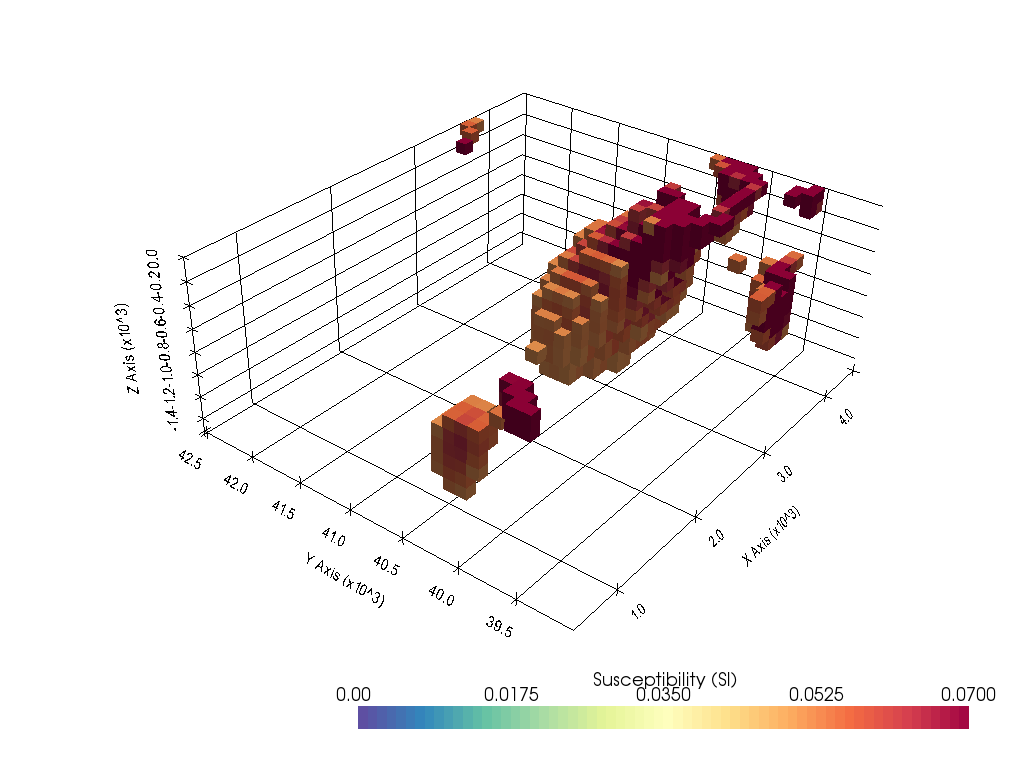

In [28]:
plot_3d_with_pyvista(inv_prob.l2model[inds_core], notebook=True, threshold=0.05)

### Recovered susceptiblity model from Lp-norm inversion

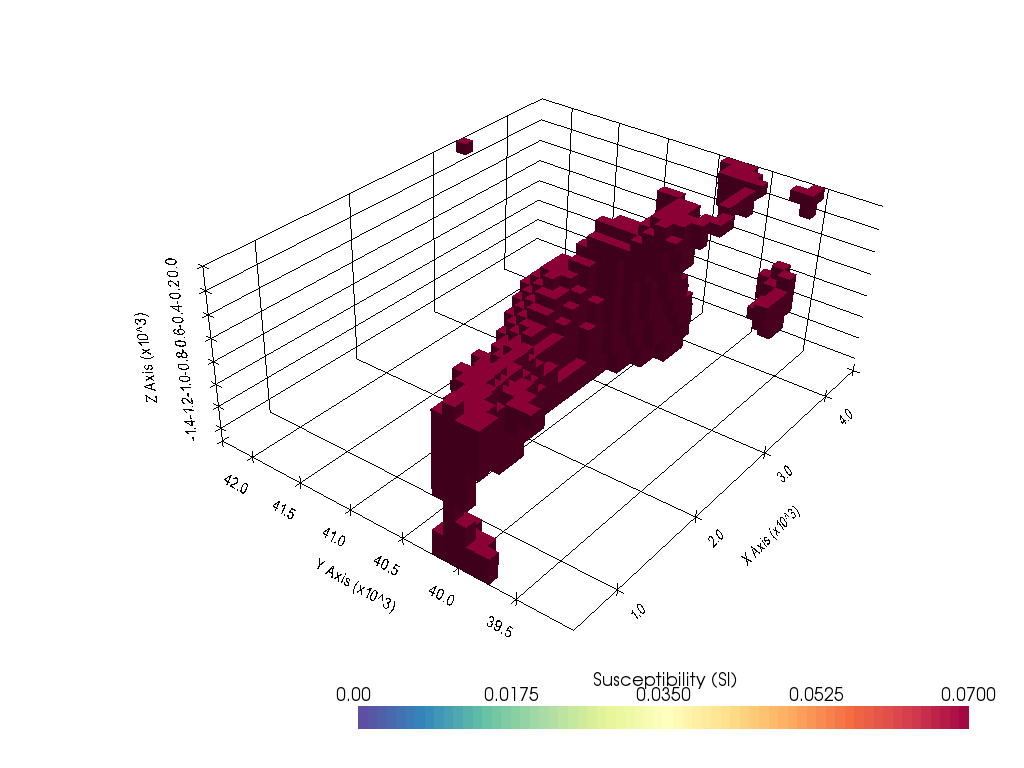

In [29]:
plot_3d_with_pyvista(susceptibility_model[inds_core], notebook=True, threshold=0.07)